<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_generalized_DuOn_best_classical_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the latest implementation
This includes;
1. agg
2. clasical and quantum communication
3. teleportaion options

flowchart LR
  %% ----------- Inputs / Config -----------
  A[Start Round t\nConfig:\n• use_deep_unfolding (DU)\n• aggregation ∈ {best, fedavg}\n• uplink_mode ∈ {classical_full, seeded_sparse, quantum}\n• downlink_mode ∈ {classical_full, seeded, quantum}\n• gamma (warm-start)\n• teleport noise, shots]:::cfg

  %% ----------- Broadcast -----------
  A --> B[Server has Global Params w^{t}\n(also prev_broadcast_params = w^{t})]
  B --> C{Downlink mode?}

  C -->|classical_full| C1[[Broadcast full w^{t}]]
  C -->|seeded (seeded mask + scale)| C2[[Send seed & mask\nClients reconstruct ŵ^{t}]]
  C -->|quantum (teleportation)| C3[[Teleport w^{t}\n(θ → θ′ via Bell pair)\nRecord fidelity, β shrink]]

  C1 --> D
  C2 --> D
  C3 --> D

  %% ----------- Local Training -----------
  subgraph S[Each Client i]
    direction TB
    D[Client i receives parameters\nw_i^{t,0} ← w^{t} (reconstructed if seeded/quantum)] --> E[Warm-start LR,PERT:\nLR_i^0 = (1-γ)LR_init + γLR_i^{t-1}\nPERT_i^0 = (1-γ)PERT_init + γPERT_i^{t-1}]
    E --> F{use_deep_unfolding?}
    F -->|Yes| G[Repeat k steps:\nfit → meta-update {LR,PERT}\nclip to trust region\nset w_i^{t,k}]
    F -->|No| H[Single fit with fixed LR, PERT\nset w_i^{t,1}]
    G --> I[Compute metrics (train/test acc,\nclient size, objective)]
    H --> I
    I --> J{Uplink mode?}
    J -->|classical_full| J1[[Send full weights w_i^{t,*}]]
    J -->|seeded_sparse| J2[[Send seeded sparse Δ_i\n(quantized top-k wrt anchor)]]
    J -->|quantum| J3[[Teleport Δ_i or w_i^{t,*}\n(log fidelity)]]
  end

  %% ----------- Aggregation -----------
  J1 --> K
  J2 --> K
  J3 --> K

  K{Aggregation?} -->|best\n(validation-gated τ-mix)| K1[[Pick client j = argmin L_val\nIf improve ≥ ε: w^{t+1} ← (1-τ)w^{t} + τ w_j]]
  K -->|fedavg| K2[[Size-weighted average\nw^{t+1} ← Σ (n_i/N) w_i^{t,*}]]

  K1 --> L[Log round metrics:\nacc_global, L_val,\nbytes_up/down, latency,\nfidelity stats, β]
  K2 --> L
  L --> M[Proceed to Round t+1]
  
  classDef cfg fill:#f5f7ff,stroke:#6b7cff,color:#222,stroke-width:1.2px;


In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
drive_root = "/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/"

In [4]:

#from configs.dataset_genome_noniid.py import *     # swap to other configs as needed

In [5]:
from common.imports import *
from configs.dataset_genome import *     # swap to other configs as needed
from io_utils.naming import stamp_now, build_param_str, make_filenames

# main.py or notebook cell
from configs.base_config import *
from io_utils.naming import build_param_str, stamp_now, make_filenames


stamp, date_str = stamp_now()

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root=drive_root,
    dataset_name=dataset_name,
    split_type=split_type,
    date_str=date_str,
    aggregation=aggregation,
    select_upload=select_upload,
    use_deep_unfolding=use_deep_unfolding,
    gamma=gamma,
    uplink_mode=uplink_mode,
    downlink_mode=downlink_mode,
    up_k_ratio=up_k_ratio,
    up_bits=up_bits,
    down_mask_ratio=down_mask_ratio,
    down_scale=down_scale,
    noise_preset=noise_preset,
    shots_used=shots_used,

)
print(best_client_csv_file)
print(global_csv_file)
print(local_csv_file)
print(validation_csv_file)

from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Qiskit: 1.4.4
qiskit_aer available?: True
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/v2/tDuQFL_Genome_NONIID_AGG-best_SU-winner_only_DU-on_g0p5_UL-classical_full__DL-classical_full_Q-off_13_10_2025_Best_Client.csv
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/v2/tDuQFL_Genome_NONIID_AGG-best_SU-winner_only_DU-on_g0p5_UL-classical_full__DL-classical_full_Q-off_13_10_2025_Global.csv
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Project/v2/tDuQFL_Genome_NONIID_AGG-best_SU-winner_only_DU-on_g0p5_UL-classical_full__DL-classical_full_Q-off_13_10_2025_Local.csv
/content/drive/MyDrive/Teleportation/tduQFL_Project_QFLvsDUQFL_AggChoice_CommEff_v2/tDuQFL_Projec

Load and Split data

run federated loop and plot

In [6]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

# examples/run_switch.py
from configs.base_config import *
from training.data_factory import build_clients_and_meta
from training.loop import run_federated_training
from training.metrics import metrics_init
import os, numpy as np

param_str = build_param_str(
    num_clients,
    num_federated_layers,
    num_deep_unfolding_iterations,
    initial_learning_rate,
    initial_perturbation,
)


# 1) Build clients + meta from config
clients, test_sequences, test_labels, num_features = build_clients_and_meta(
    dataset_name=dataset_name,
    split_type=split_type,
    num_clients=num_clients,
    num_epochs=num_epochs,
    samples_per_epoch=samples_per_epoch,
    word_size=word_size,
    global_seed=global_seed,
    mnist_n_features=mnist_n_features,
    mnist_digit_a=mnist_digit_a,
    mnist_digit_b=mnist_digit_b,
    breast_pca_n_features=breast_pca_n_features,
    non_iid_ratio=non_iid_ratio,
    quantity_variation=quantity_variation,
    noniid_seed=noniid_seed,
)

# 2) Validation set (use test as val if you don’t have a separate split)
X_val, y_val = test_sequences, test_labels

# 3) Outputs
os.makedirs(drive_root, exist_ok=True)


metrics = metrics_init(log_path=os.path.join(drive_root, "round_metrics.csv"))

# 4) Train
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences, test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    metrics=metrics,
    aggregation=aggregation,                  # "best" or "fedavg"
    select_upload=select_upload,              # "all" or "winner_only" (used for best)
    use_deep_unfolding=use_deep_unfolding,    # True/False
    uplink_mode=uplink_mode,                  # "classical_full" | "seeded_sparse" | "quantum"
    downlink_mode=downlink_mode,              # "classical_full" | "seeded" | "quantum"
    down_seed_base=down_seed_base,
    down_scale=down_scale,
    down_mask_ratio=down_mask_ratio,
    up_bits=up_bits,
    up_k_ratio=up_k_ratio,
    use_teleportation_backend=True,
    noise_preset=noise_preset,
    shots_used=shots_used,
    client_hparams_csv_file=os.path.join(drive_root, f"hparams_{dataset_name}_{split_type}_{param_str}.csv"),
)

print("Global accuracy per round:", global_acc)

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.457435 step=0.06773 g_raw=+0.031 g_sm=+0.005 acc=1 | LR→0.100020 PERT→0.100000 (scale=0.04)
[meta] cb#010 loss=0.446709 step=0.06255 g_raw=+0.033 g_sm=+0.011 acc=1 | LR→0.100040 PERT→0.100000 (scale=0.04)
[meta] cb#015 loss=0.440324 step=0.01929 g_raw=+0.012 g_sm=+0.013 acc=1 | LR→0.100060 PERT→0.100000 (scale=0.04)
[meta] cb#020 loss=0.437907 step=0.03435 g_raw=+0.016 g_sm=+0.013 acc=1 | LR→0.100080 PERT→0.100000 (scale=0.04)
[meta] cb#025 loss=0.433438 step=0.04267 g_raw=+0.022 g_sm=+0.014 acc=1 | LR→0.100100 PERT→0.100000 (scale=0.04)
[client 0 | unfold 1] LR 0.100000->0.100100, PERT 0.100000->0.100000 | g_raw_mean=+0.021, g_sm_mean=+0.010
[meta] cb#030 loss=0.421539 step=0.02779 g_raw=+0.014 g_sm=+0.017 acc=1 | LR→0.100120 PERT→0.100000 (scale=0.04)
[meta] cb#035 loss=0.413581 step=0.08892 g_raw=+0.043 g_sm=+0.019 acc=1 | LR→0.100140 PERT→0.100000 (scale=0.04)
[meta] cb#040 loss=0.404167 step=

Training Progress:  10%|█         | 1/10 [34:30<5:10:37, 2070.80s/it]

[Round   0] acc_g=0.545 (μ=0.509, σ=0.021, FG=0.044) | t=2012.321s, val=0.726 | TEL=FALSE
[Round 0] ↓=80B ↑=80B | (Σ↓=80B, Σ↑=80B)
[Round 1] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.470104 step=0.04668 g_raw=+0.023 g_sm=+0.003 acc=1 | LR→0.100523 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.462142 step=0.03059 g_raw=+0.014 g_sm=+0.008 acc=1 | LR→0.100543 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.458970 step=0.01499 g_raw=+0.008 g_sm=+0.010 acc=1 | LR→0.100564 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.450744 step=0.005193 g_raw=+0.003 g_sm=+0.013 acc=1 | LR→0.100584 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.445453 step=0.0001417 g_raw=-0.001 g_sm=+0.014 acc=1 | LR→0.100604 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.100503->0.100604, PERT 0.100001->0.100001 | g_raw_mean=+0.019, g_sm_mean=+0.009
[meta] cb#030 loss=0.436260 step=0.07182 g_raw=+0.037 g_sm=+0.016 acc=1 | LR→0.100624 PERT→0.100001 (scale=0.04)
[meta] cb#03

Training Progress:  20%|██        | 2/10 [1:08:12<4:32:15, 2041.88s/it]

[Round   1] acc_g=0.514 (μ=0.502, σ=0.012, FG=0.026) | t=1962.842s, val=0.828 | TEL=FALSE
[Round 1] ↓=80B ↑=80B | (Σ↓=160B, Σ↑=160B)
[Round 2] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.391170 step=0.01658 g_raw=+0.006 g_sm=+0.003 acc=1 | LR→0.100777 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.379953 step=0.05112 g_raw=+0.025 g_sm=+0.009 acc=1 | LR→0.100798 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.376786 step=0.0408 g_raw=+0.019 g_sm=+0.011 acc=1 | LR→0.100818 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.373872 step=0.01902 g_raw=+0.010 g_sm=+0.012 acc=1 | LR→0.100838 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.365896 step=0.01898 g_raw=+0.011 g_sm=+0.015 acc=1 | LR→0.100858 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.100757->0.100858, PERT 0.100001->0.100001 | g_raw_mean=+0.020, g_sm_mean=+0.009
[meta] cb#030 loss=0.361964 step=0.03889 g_raw=+0.020 g_sm=+0.015 acc=1 | LR→0.100878 PERT→0.100001 (scale=0.04)
[meta] cb#035 

Training Progress:  30%|███       | 3/10 [1:45:06<4:07:23, 2120.51s/it]

[Round   2] acc_g=0.665 (μ=0.534, σ=0.067, FG=0.117) | t=2156.133s, val=0.621 | TEL=FALSE
[Round 2] ↓=80B ↑=80B | (Σ↓=240B, Σ↑=240B)
[Round 3] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.445778 step=0.1763 g_raw=+0.091 g_sm=+0.006 acc=1 | LR→0.100906 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.435527 step=0.06444 g_raw=+0.031 g_sm=+0.011 acc=1 | LR→0.100926 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.432808 step=0.009356 g_raw=+0.004 g_sm=+0.011 acc=1 | LR→0.100946 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.427907 step=0.03109 g_raw=+0.017 g_sm=+0.013 acc=1 | LR→0.100966 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.418510 step=0.03601 g_raw=+0.020 g_sm=+0.016 acc=1 | LR→0.100987 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.100885->0.100987, PERT 0.100001->0.100001 | g_raw_mean=+0.022, g_sm_mean=+0.010
[meta] cb#030 loss=0.407621 step=0.08479 g_raw=+0.041 g_sm=+0.019 acc=1 | LR→0.101007 PERT→0.100001 (scale=0.04)
[meta] cb#035

Training Progress:  40%|████      | 4/10 [2:23:05<3:38:19, 2183.27s/it]

[Round   3] acc_g=0.680 (μ=0.542, σ=0.069, FG=0.116) | t=2219.354s, val=0.576 | TEL=FALSE
[Round 3] ↓=80B ↑=80B | (Σ↓=320B, Σ↑=320B)
[Round 4] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.532186 step=0.04337 g_raw=+0.024 g_sm=+0.003 acc=1 | LR→0.100971 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.519216 step=0.05106 g_raw=+0.026 g_sm=+0.010 acc=1 | LR→0.100991 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.512754 step=0.02479 g_raw=+0.011 g_sm=+0.011 acc=1 | LR→0.101011 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.511570 step=0.02268 g_raw=+0.012 g_sm=+0.011 acc=1 | LR→0.101031 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.503903 step=0.02939 g_raw=+0.017 g_sm=+0.014 acc=1 | LR→0.101051 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.100950->0.101051, PERT 0.100001->0.100001 | g_raw_mean=+0.019, g_sm_mean=+0.008
[meta] cb#030 loss=0.489569 step=0.0614 g_raw=+0.032 g_sm=+0.018 acc=1 | LR→0.101072 PERT→0.100001 (scale=0.04)
[meta] cb#035 

Training Progress:  50%|█████     | 5/10 [2:57:41<2:58:41, 2144.26s/it]

[Round   4] acc_g=0.591 (μ=0.525, σ=0.040, FG=0.088) | t=2017.382s, val=0.647 | TEL=FALSE
[Round 4] ↓=80B ↑=80B | (Σ↓=400B, Σ↑=400B)
[Round 5] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.461969 step=0.04028 g_raw=+0.022 g_sm=+0.004 acc=1 | LR→0.101003 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.447075 step=0.05379 g_raw=+0.026 g_sm=+0.011 acc=1 | LR→0.101024 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.437377 step=0.04974 g_raw=+0.022 g_sm=+0.015 acc=1 | LR→0.101044 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.431265 step=0.1077 g_raw=+0.050 g_sm=+0.016 acc=1 | LR→0.101064 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.428313 step=0.01419 g_raw=+0.007 g_sm=+0.015 acc=1 | LR→0.101084 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.100983->0.101084, PERT 0.100001->0.100001 | g_raw_mean=+0.022, g_sm_mean=+0.011
[meta] cb#030 loss=0.425790 step=0.03809 g_raw=+0.015 g_sm=+0.015 acc=1 | LR→0.101105 PERT→0.100001 (scale=0.04)
[meta] cb#035 

Training Progress:  60%|██████    | 6/10 [3:23:40<2:09:41, 1945.27s/it]

[Round   5] acc_g=0.585 (μ=0.542, σ=0.035, FG=0.072) | t=1501.351s, val=0.688 | TEL=FALSE
[Round 5] ↓=80B ↑=80B | (Σ↓=480B, Σ↑=480B)
[Round 6] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.483537 step=0.09782 g_raw=+0.053 g_sm=+0.008 acc=1 | LR→0.101020 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.477347 step=0.08447 g_raw=+0.045 g_sm=+0.010 acc=1 | LR→0.101040 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.467932 step=0.03096 g_raw=+0.015 g_sm=+0.014 acc=1 | LR→0.101060 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.448710 step=0.02443 g_raw=+0.012 g_sm=+0.017 acc=1 | LR→0.101081 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.439045 step=0.04064 g_raw=+0.020 g_sm=+0.019 acc=1 | LR→0.101101 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.101000->0.101101, PERT 0.100001->0.100001 | g_raw_mean=+0.027, g_sm_mean=+0.012
[meta] cb#030 loss=0.419093 step=0.0678 g_raw=+0.029 g_sm=+0.024 acc=1 | LR→0.101121 PERT→0.100001 (scale=0.04)
[meta] cb#035 

Training Progress:  70%|███████   | 7/10 [3:57:45<1:38:53, 1977.88s/it]

[Round   6] acc_g=0.514 (μ=0.502, σ=0.012, FG=0.026) | t=1985.199s, val=0.716 | TEL=FALSE
[Round 6] ↓=80B ↑=80B | (Σ↓=560B, Σ↑=560B)
[Round 7] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.440614 step=0.1486 g_raw=+0.084 g_sm=+0.006 acc=1 | LR→0.101028 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.422515 step=0.02035 g_raw=+0.007 g_sm=+0.012 acc=1 | LR→0.101049 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.404361 step=0.1309 g_raw=+0.062 g_sm=+0.017 acc=1 | LR→0.101069 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.364792 step=0.1726 g_raw=+0.083 g_sm=+0.024 acc=1 | LR→0.101089 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.358325 step=0.03706 g_raw=+0.021 g_sm=+0.023 acc=1 | LR→0.101109 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.101008->0.101109, PERT 0.100001->0.100001 | g_raw_mean=+0.032, g_sm_mean=+0.014
[meta] cb#030 loss=0.350452 step=0.05737 g_raw=+0.026 g_sm=+0.024 acc=1 | LR→0.101130 PERT→0.100002 (scale=0.04)
[meta] cb#035 lo

Training Progress:  80%|████████  | 8/10 [4:27:28<1:03:52, 1916.10s/it]

[Round   7] acc_g=0.640 (μ=0.565, σ=0.059, FG=0.135) | t=1725.672s, val=0.557 | TEL=FALSE
[Round 7] ↓=80B ↑=80B | (Σ↓=640B, Σ↑=640B)
[Round 8] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.455084 step=0.02246 g_raw=+0.012 g_sm=+0.003 acc=1 | LR→0.101032 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.439606 step=0.03954 g_raw=+0.023 g_sm=+0.010 acc=1 | LR→0.101053 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.431694 step=0.04727 g_raw=+0.026 g_sm=+0.013 acc=1 | LR→0.101073 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.419818 step=0.02932 g_raw=+0.014 g_sm=+0.017 acc=1 | LR→0.101093 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.413026 step=0.06875 g_raw=+0.035 g_sm=+0.018 acc=1 | LR→0.101113 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.101012->0.101113, PERT 0.100001->0.100001 | g_raw_mean=+0.024, g_sm_mean=+0.011
[meta] cb#030 loss=0.393905 step=0.09246 g_raw=+0.048 g_sm=+0.023 acc=1 | LR→0.101134 PERT→0.100001 (scale=0.04)
[meta] cb#035

Training Progress:  90%|█████████ | 9/10 [4:59:00<31:48, 1908.30s/it]  

[Round   8] acc_g=0.622 (μ=0.533, σ=0.047, FG=0.089) | t=1832.947s, val=0.576 | TEL=FALSE
[Round 8] ↓=80B ↑=80B | (Σ↓=720B, Σ↑=720B)
[Round 9] Agg=best | Uplink=classical_full | Downlink=classical_full
[meta] cb#005 loss=0.543738 step=0.00212 g_raw=+0.002 g_sm=+0.004 acc=1 | LR→0.101034 PERT→0.100001 (scale=0.04)
[meta] cb#010 loss=0.518544 step=0.05634 g_raw=+0.030 g_sm=+0.014 acc=1 | LR→0.101055 PERT→0.100001 (scale=0.04)
[meta] cb#015 loss=0.505892 step=0.05443 g_raw=+0.026 g_sm=+0.017 acc=1 | LR→0.101075 PERT→0.100001 (scale=0.04)
[meta] cb#020 loss=0.493867 step=0.01034 g_raw=+0.005 g_sm=+0.019 acc=1 | LR→0.101095 PERT→0.100001 (scale=0.04)
[meta] cb#025 loss=0.479181 step=0.0007919 g_raw=-0.001 g_sm=+0.022 acc=1 | LR→0.101115 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR 0.101014->0.101115, PERT 0.100001->0.100001 | g_raw_mean=+0.030, g_sm_mean=+0.014
[meta] cb#030 loss=0.477770 step=0.05008 g_raw=+0.023 g_sm=+0.019 acc=1 | LR→0.101136 PERT→0.100001 (scale=0.04)
[meta] cb#0

Training Progress: 100%|██████████| 10/10 [5:24:50<00:00, 1949.00s/it]

[Round   9] acc_g=0.554 (μ=0.514, σ=0.025, FG=0.057) | t=1490.195s, val=0.626 | TEL=FALSE
[Round 9] ↓=80B ↑=80B | (Σ↓=800B, Σ↑=800B)
Global accuracy per round: [0.545, 0.514, 0.665, 0.68, 0.591, 0.585, 0.514, 0.64, 0.622, 0.554]


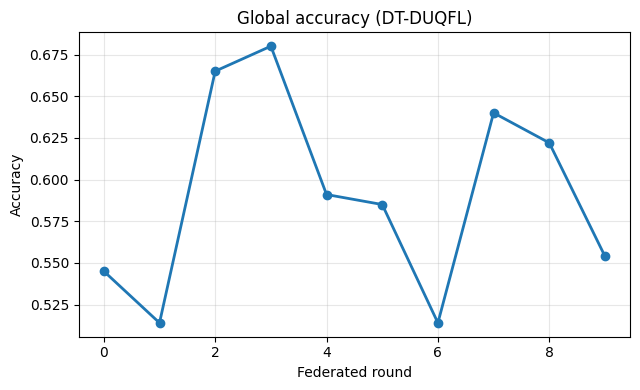

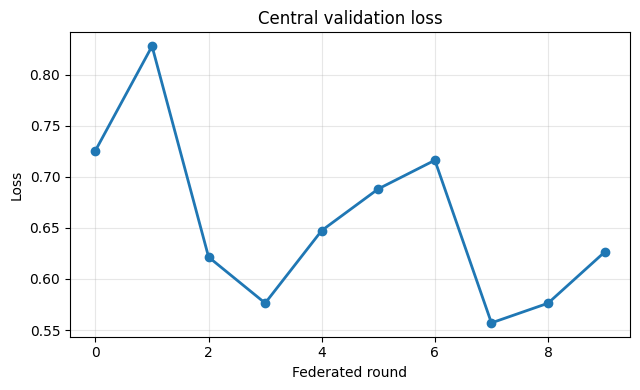

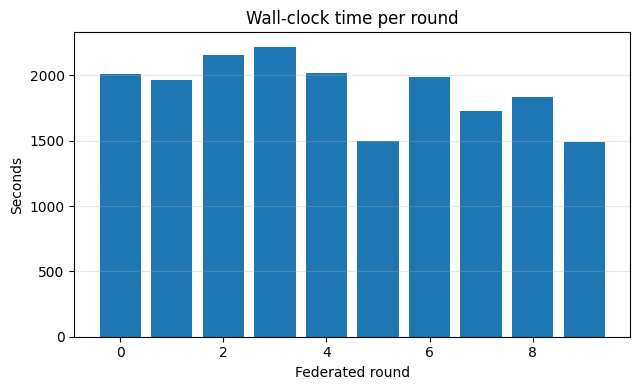

In [7]:
# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)